# Simple classification example with missing feature handling and parameter tuning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/classification/classification_with_parameter_tuning_tutorial.ipynb)

This tutorial will show you how to use CatBoost to train binary classifier for data with missing feature and how to do hyper-parameter tuning using Hyperopt framework.

Gaps in data may be a challenge to handle correctly, especially when they appear in categorical features, this tutorial will also give some advices how to handle them during model application.

In [1]:
# !pip install -q numpy pandas catboost hyperopt 'scikit-learn<1.8' matplotlib 

In [2]:
import catboost
print(catboost.__version__)

1.2.8


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [4]:
import catboost as cb
import catboost.datasets as cbd
import catboost.utils as cbu
import numpy as np
import pandas as pd
import hyperopt
import sys

# print module versions for reproducibility
print('CatBoost version {}'.format(cb.__version__))
print('NumPy version {}'.format(np.__version__))
print('Pandas version {}'.format(pd.__version__))
print('Hyperopt version {}'.format(hyperopt.__version__))

d:\Softwares\anaconda3\envs\catboost\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


CatBoost version 1.2.8
NumPy version 2.3.5
Pandas version 2.3.3
Hyperopt version 0.2.7


In [5]:
# We are going to use UCI Adult Data Set because it has both numerical and categorical 
# features and also has missing features.
print(cbd.adult.__doc__)


    Download "Adult Data Set" [1] from UCI Machine Learning Repository.

    Will return two pandas.DataFrame-s, first with train part (adult.data) and second with test part
    (adult.test) of the dataset.

    [1]: https://archive.ics.uci.edu/ml/datasets/Adult
    


In [6]:
train_subin, test_subin = cbd.adult()

In [7]:
train_rows = train_subin.shape[0]
test_rows = test_subin.shape[0]
ratio = train_rows / (train_rows + test_rows)
print(f"Train size: {train_rows}, Test size: {test_rows}, Train ratio: {ratio:.2f}, Test ratio: {1 - ratio:.2f}")

Train size: 32561, Test size: 16281, Train ratio: 0.67, Test ratio: 0.33


In [8]:
train_subin.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [9]:
train_subin.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
32556,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
32557,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
32558,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
32559,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K
32560,52.0,Self-emp-inc,287927.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024.0,0.0,40.0,United-States,>50K


In [10]:
test_subin.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [11]:
def get_fixed_adult():
    train, test = cbd.adult()
    
    # CatBoost doesn't support pandas.DataFrame missing values for categorical features out 
    # of the box (seed issue #571 on GitHub or issue MLTOOLS-2785 in internal tracker). So 
    # we have to replace them with some designated string manually. 
    for dataset in (train, test, ): # Loops over both the train and test datasets.
        # For each dataset, finds all column names where the column's data type is np.object (i.e., object type, typically used for strings/categorical data in pandas).
        for name in (name for name, dtype in dict(dataset.dtypes).items() if dtype == object):
            # For each such column, replaces all missing values (NaN) with the string 'nan' in place.
            dataset[name].fillna('nan', inplace=True)
    # CatBoost (and many other ML libraries) cannot handle missing values in categorical columns directly, so this code ensures all missing categorical values are replaced with a placeholder string before training.
    # CatBoost doesn't support `class_names` in `Pool` c-tor (see MLTOOLS-2799 in internal 
    # tracker) so we have to convert them manually

    # This code converts the target column (income) in both the train and test datasets from string labels to numeric labels.
    class_names = ('<=50K', '>50K', ) # This is just a tuple listing the original class names for reference.
    for dataset in (train, test, ): # Loops over both the train and test datasets.
        # For each dataset, maps the income column values: '<=50K' to 0.0 and '>50K' to 1.0
        dataset.income = dataset.income.map({'<=50K': 0., '>50K': 1.})
    
    # This code splits the train and test DataFrames into features and target variable

    # All columns except 'income' from the training set (features).
    X_train, y_train = train.drop('income', axis=1), train.income
    # All columns except 'income' from the test set (features).
    X_test, y_test = test.drop('income', axis=1), test.income
    return X_train, y_train, X_test, y_test

In [12]:
X_train, y_train, X_test, y_test = get_fixed_adult()

C:\Users\subin\AppData\Local\Temp\ipykernel_24132\3073226975.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[name].fillna('nan', inplace=True)
C:\Users\subin\AppData\Local\Temp\ipykernel_24132\3073226975.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

In [13]:
X_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [14]:
X_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,nan,103497.0,Some-college,10.0,Never-married,nan,Own-child,White,Female,0.0,0.0,30.0,United-States


In [15]:
print('train: {}\ntest: {}'.format(y_train.value_counts(), y_test.value_counts()))

train: income
0.0    24720
1.0     7841
Name: count, dtype: int64
test: income
0.0    12435
1.0     3846
Name: count, dtype: int64


Ok, so our task here is to predict whether person makes over 50K per year. We'll use `CatBoostClassifier` to solve this problem. In CatBoost there are two possible objectives for binary classification: `Logloss` and `CrossEntropy`, we'll use the first one because second one works better with probabilities (while we have solid classes for each case).

We are also going to use [Hyperopt](https://github.com/hyperopt/hyperopt) for hyper-parameter optimization because it support optimization on a single host and is one of the most common solutions for hyper-parameter optimization. Though there is a number of other hyper-parameter optimization frameworks like [Chocolate](https://github.com/AIworx-Labs/chocolate) and [Skopt](https://scikit-optimize.github.io).   


#### A "single host" means running all computations on one computer (one machine), not distributed across multiple servers or a computing cluster. In this context, Hyperopt will perform hyper-parameter optimization using only the resources (CPU/GPU, memory) of your local machine or a single server, rather than parallelizing the search over many machines.

#### Logloss (Logarithmic Loss) and CrossEntropy are both loss functions used for classification tasks, especially binary and multiclass classification.

In [16]:
class UciAdultClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}
    
    # hyperopt optimizes an objective using `__call__` method (e.g. by doing 
    # `foo(hyper_params)`), so we provide one
    def __call__(self, hyper_params):
        # join hyper-parameters provided by hyperopt with hyper-parameters 
        # provided by the user
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()
        
        # We use cross-validation for objective evaluation, to avoid overfitting
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=20181224,
            verbose=False)
        
        # scores returns a dictionary with mean and std (per-fold) of metric 
        # value for each cv iteration, we choose minimal value of objective 
        # mean (though it will be better to choose minimal value among all folds)
        # because noise is additive
        max_mean_auc = np.max(scores['test-AUC-mean'])
        print('evaluated score={}'.format(max_mean_auc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -max_mean_auc, 'status': hyperopt.STATUS_OK}

In [17]:
def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.2, 1.0),
        'depth': hyperopt.hp.randint('depth', 7),
        'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 10)}
    objective = UciAdultClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.default_rng(seed=20181224))
    return best

def train_best_model(X, y, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization
    # catboost.Pool is a special data structure in the CatBoost library used to efficiently store
    # and pass datasets (features and labels) to CatBoost models for training, evaluation, and prediction.
    # catboost.Pool helps optimize memory usage and speed when working with large datasets.
    # It can handle numerical and categorical features.
    # It supports additional information like feature names, categorical feature indices, sample weights, etc.
    # It is optimized for CatBoost's internal processing.
    dataset = cb.Pool(X, y, cat_features=np.where(X.dtypes != float)[0])
    # This line prepares your data for CatBoost, marking categorical columns so the algorithm can process them correctly.
    # X = Your features (usually a pandas DataFrame).
    # y = Your target labels (usually a pandas Series or numpy array).
    # np.where(X.dtypes != float)[0] = This finds the indices of columns in X that are not of type float (i.e., likely categorical features), and tells CatBoost which columns are categorical.
    # The Pool object stores your data and information about which features are categorical, so CatBoost can handle them properly during training and prediction.

    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [18]:
# make it True if your want to use GPU for training
have_gpu = True
# have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
# If use_optimal_pretrained_params is True, the function skips the time-consuming hyperparameter search and uses hardcoded best parameters.
# If False, it runs Hyperopt to search for the best hyperparameters.
use_optimal_pretrained_params = True
# number of iterations of hyper-parameter search
hyperopt_iterations = 30

const_params = dict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'custom_metric': ['AUC'],
    'iterations': 100,
    'random_seed': 20181224})

model, params = train_best_model(
    X_train, y_train, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)
print('best params are {}'.format(params), file=sys.stdout)

"""
If you do not use file=sys.stdout in the print() function, the output will still be printed to the console 
(standard output) by default.
So, for most cases, removing file=sys.stdout will not change the behavior—you will still see 
the output in your terminal or notebook output cell.
"""

Default metric period is 5 because AUC is/are not implemented for GPU


best params are {'learning_rate': 0.4234185321620083, 'depth': 5, 'l2_leaf_reg': 9.464266235679002, 'task_type': 'GPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 20181224}


'\nIf you do not use file=sys.stdout in the print() function, the output will still be printed to the console \n(standard output) by default.\nSo, for most cases, removing file=sys.stdout will not change the behavior—you will still see \nthe output in your terminal or notebook output cell.\n'

In [19]:
with open("best_params.txt", "w") as f:
    print('best params are {}'.format(params), file=f)

In [20]:
def calculate_score_on_dataset_and_show_graph(X, y, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
    pl.style.use('ggplot')
    
    dataset = cb.Pool(X, y, cat_features=np.where(X.dtypes != float)[0])
    fpr, tpr, _ = cbu.get_roc_curve(model, dataset, plot=True)
    auc = sklearn.metrics.auc(fpr, tpr)
    return auc

#### ROC curve stands for Receiver Operating Characteristic curve.
It is a graphical plot used to show the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

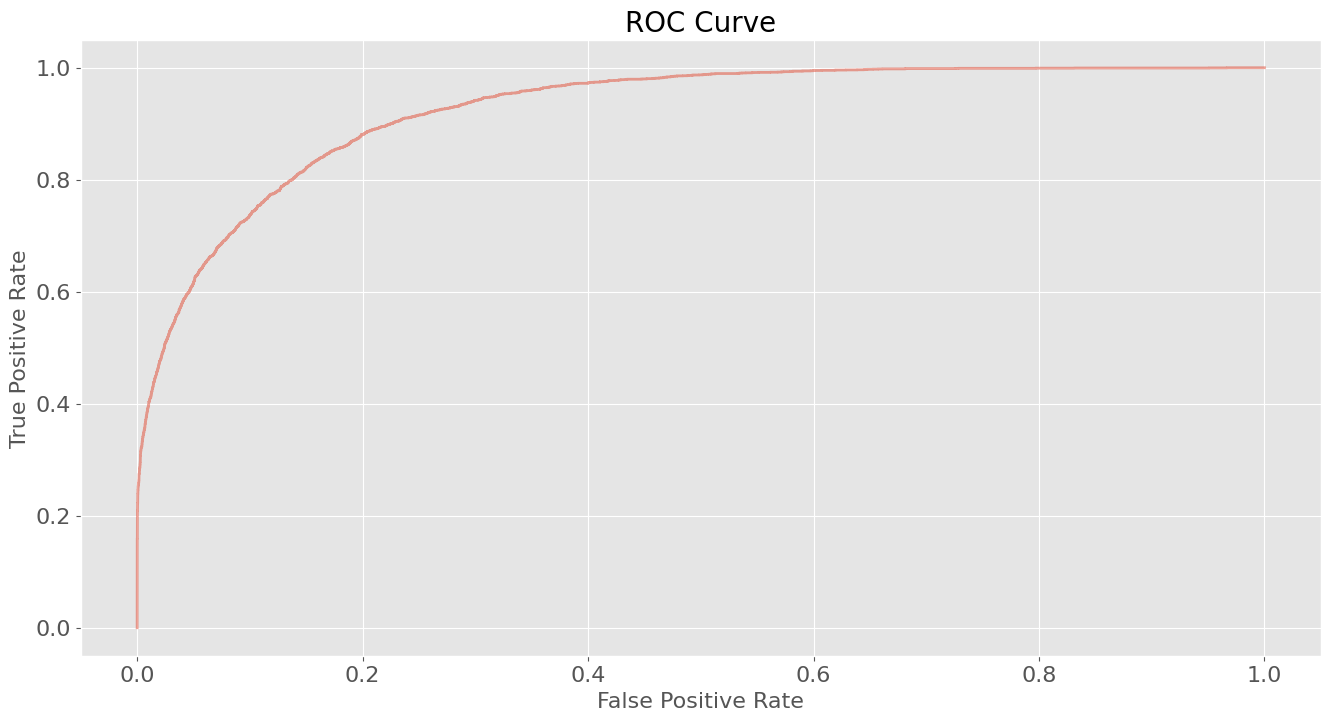

0.9240321852520261

In [21]:
calculate_score_on_dataset_and_show_graph(X_test, y_test, model)